In [24]:
import os
import warnings

import pandas as pd

warnings.filterwarnings("ignore")

In [25]:
from darts import TimeSeries
from darts.metrics import mae, mase, mse, ope
from darts.models import (
    ARIMA,
    FFT,
    AutoARIMA,
    ExponentialSmoothing,
    NaiveDrift,
    NaiveMean,
    NaiveMovingAverage,
    NaiveSeasonal,
    Theta,
)
from darts.utils.statistics import check_seasonality

In [26]:
# Evaluation Metrics
def eval_model(model, ts_train, ts_test, name=None):

    if name is None:
        name = type(model).__name__

    model.fit(ts_train)

    y_pred = model.predict(len(ts_test))

    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series=ts_test, pred_series=y_pred),
        "MSE": mse(actual_series=ts_test, pred_series=y_pred),
        "MASE": mase(actual_series=ts_test, pred_series=y_pred, insample=ts_train),
        # "Forecast Bias": forecast_bias(actual_series=ts_test, pred_series=y_pred),
    }


def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()

    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name

    return y_pred

In [27]:
import sys

# Adicionar a pasta 'src' ao caminho do sistema
sys.path.append(os.path.abspath(os.path.join("..", "src")))

# Agora você pode importar o módulo utils Ou importar funções específicas do módulo
from ts_plots import plot_forecast
from utils import LogTime, compact_5G_dataset

In [28]:
checkpoints_path = os.path.join(os.pardir, "checkpoints")
df_static = pd.read_parquet(os.path.join(checkpoints_path, "5G_df_static.parquet.gzip"))

In [29]:
# df_static_compact = compact_5G_dataset(df_static)

In [30]:
static_uids = df_static.Uid.unique().tolist()
display(static_uids)

['FWgQihFY',
 'JuJhmMUS',
 'j9aQcpma',
 'JX5ctgXk',
 'GkLNvAxk',
 'L2Gc6KFE',
 'AMcyZBRZ',
 'aTx448ZX',
 'VVtpjXhe',
 'CSyiTD67',
 '45tHAXkk',
 'm3xmyiFu',
 'eoHUrkbG',
 'Jg5gZWT9',
 '4u4uNEHg',
 'Zk7wQePj',
 'X5rS2fPs',
 'KWkqdhLs',
 'in2JGSH5',
 'mDVN6DYG',
 'NNM8S6cc',
 'ThHnpx5h',
 'nQK8dP5x']

In [31]:
test_df = df_static[df_static.Uid == static_uids[10]][
    ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
]

In [32]:
test_df

,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-12-16 13:40:04,-103.0,-15.0,1.0,15.0,-90.0
2019-12-16 13:40:05,-102.0,-16.0,7.0,15.0,-90.0
2019-12-16 13:40:06,-102.0,-16.0,7.0,15.0,-90.0
2019-12-16 13:40:07,-104.0,-14.0,-7.0,11.0,-88.0
2019-12-16 13:40:08,-104.0,-14.0,-7.0,11.0,-88.0
...,...,...,...,...,...
2019-12-16 14:17:59,-98.0,-11.0,2.0,14.0,-87.0
2019-12-16 14:18:00,-98.0,-11.0,2.0,14.0,-87.0
2019-12-16 14:18:01,-99.0,-13.0,8.0,8.0,-89.0


In [33]:
ts_static = TimeSeries.from_dataframe(
    test_df,
    value_cols=["RSRP", "RSRQ", "SNR", "CQI", "RSSI"],
    fill_missing_dates=True,  # Adiciona NaN para os segundos ausentes
    freq="s",
)

In [34]:
# Separar os timeseries
ts_train, ts_actual = ts_static.split_after(0.8)

# Uni

<Axes: xlabel='Timestamp'>

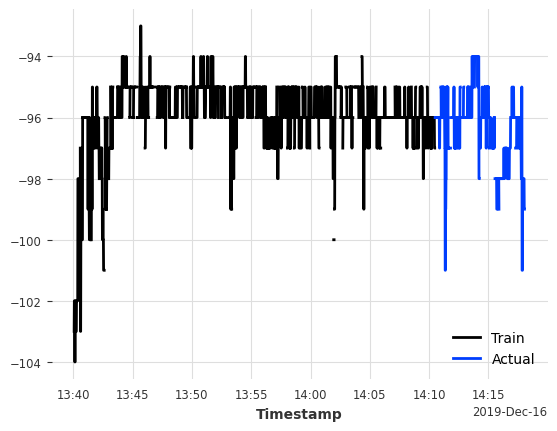

In [35]:
ts_train["RSRP"].plot(label="Train")
ts_actual["RSRP"].plot(label="Actual")

# Multi

<Axes: xlabel='Timestamp'>

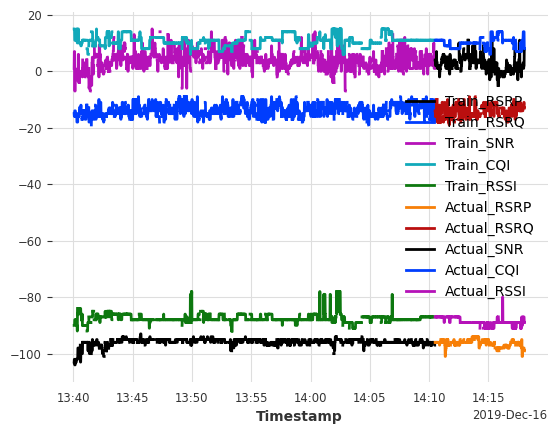

In [36]:
ts_train.plot(label="Train")
ts_actual.plot(label="Actual")

# Baseline Forecast

In [56]:
metric_record = []

## Naive Forecast

---

Example only for RSRP

In [37]:
uni_variable = "RSRP"
name = "Naive"
naive_model = NaiveSeasonal(K=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(
        naive_model, ts_train[uni_variable], ts_actual[uni_variable], name=name
    )

Time Elapsed: 0 microseconds


In [38]:
metrics

{'Algorithm': 'Naive',
 'MAE': 1.1296758104738154,
 'MSE': 1.9975062344139651,
 'MASE': 4.420754472201001}

<Axes: xlabel='Timestamp'>

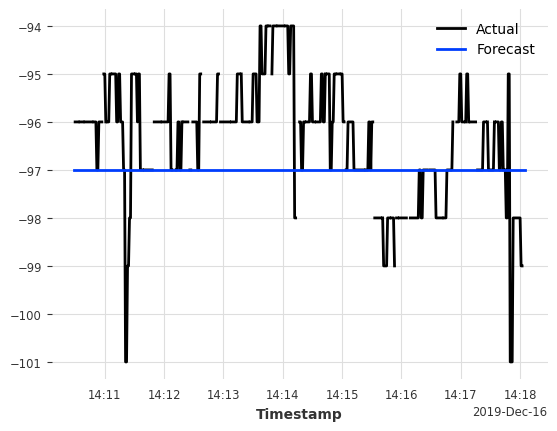

In [39]:
ts_actual["RSRP"].plot(label="Actual")
y_pred["RSRP"].plot(label="Forecast")

---

For all Channel Quality KPIs

## Naive

In [40]:
name = "Naive"
naive_model = NaiveSeasonal(K=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_actual, name=name)
display(metrics)

Time Elapsed: 0 microseconds


{'Algorithm': 'Naive',
 'MAE': 1.819950124688279,
 'MSE': 5.9635910224438895,
 'MASE': 4.488641418159473}

In [41]:
fig = plot_forecast(
    ts_actual,
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()
# fig.write_image("imgs/chapter_4/ma.png")

## Naive Drift

In [42]:
name = "Naive Drift"
naive_model = NaiveDrift()
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_actual, name=name)
display(metrics)

Time Elapsed: 0 microseconds


{'Algorithm': 'Naive Drift',
 'MAE': 1.9177932362077263,
 'MSE': 6.372265349462026,
 'MASE': 4.773367643237813}

In [43]:
fig = plot_forecast(
    ts_actual,
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()
# fig.write_image("imgs/chapter_4/ma.png")

## Naive Moving Average

In [44]:
name = "Naive Moving Average"
naive_model = NaiveMovingAverage(6)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_actual, name=name)
display(metrics)

Time Elapsed: 0 microseconds


{'Algorithm': 'Naive Moving Average',
 'MAE': 1.7426926043665993,
 'MSE': 5.272951399153067,
 'MASE': 4.361270057619498}

In [45]:
fig = plot_forecast(
    ts_actual,
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()
# fig.write_image("imgs/chapter_4/ma.png")

## Seasonal Naive Forecast

In [46]:
# Check Seasonality
for col in ts_train.columns:
    display(f"{col}: Check Seasonality: {check_seasonality(ts_train[col])}")

'RSRP: Check Seasonality: (False, 0)'

'RSRQ: Check Seasonality: (False, 0)'

'SNR: Check Seasonality: (False, 0)'

'CQI: Check Seasonality: (False, 0)'

'RSSI: Check Seasonality: (False, 0)'

In [47]:
name = "Seasonal Naive Forecast"
naive_model = NaiveSeasonal(K=60)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_actual, name=name)
display(metrics)

Time Elapsed: 0 microseconds


{'Algorithm': 'Seasonal Naive Forecast',
 'MAE': 2.1092957746478875,
 'MSE': 8.3943661971831,
 'MASE': 4.710850399389919}

In [48]:
fig = plot_forecast(
    ts_actual,
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()
# fig.write_image("imgs/chapter_4/ma.png")

## Exponential Smoothing Forecast

Only supports univariate

> Não funciou precisso identificar quais manipulações serão necessárias na série.

> 💡 Preciso tambem adaptar a função plot_forecast() para trabalhar com classes univariadas para as três métricas.

In [49]:
from darts.utils.utils import ModelMode, SeasonalityMode

In [50]:
name = "Exponential Smoothing"
uni_variable = "RSRP"
# Suppress FutureWarning
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=FutureWarning)

# ets_model = ExponentialSmoothing(
#     trend= ModelMode.ADDITIVE,
#     damped=True,
#     seasonal= SeasonalityMode.ADDITIVE,
#     seasonal_periods=10,
#     random_state=42,
# )

ets_model = ExponentialSmoothing(
    trend=ModelMode.ADDITIVE,
    seasonal=SeasonalityMode.ADDITIVE,
    seasonal_periods=7,
    random_state=42,
)
with LogTime() as timer:
    y_pred, metrics = eval_model(
        ets_model, ts_train["RSRP"], ts_actual["RSRP"], name=name
    )
display(metrics)

Time Elapsed: 0 microseconds


{'Algorithm': 'Exponential Smoothing', 'MAE': nan, 'MSE': nan, 'MASE': nan}

## ARIMA

Only supports univariate

> Preciso verificar quais parâmetros precisam ser aplicados ao AutoARIMA.

> ARIMA assume que a série é *estacionária*: que suas propriedades permanecem constantes pelo tempo.

In [51]:
name = "ARIMA"
# AutoARIMA will take a lot time for long time series
# arima_model = AutoARIMA(max_p=5, max_q=3, m=48, seasonal=False)
arima_model = ARIMA(p=2, d=1, q=1, seasonal_order=(1, 1, 1, 60))
# Taking only latest 8000 points for training (Time constraints)
# Reduce 8000 if it is taking too much time or consuming all the memory

with LogTime() as timer:
    y_pred, metrics = eval_model(
        arima_model, ts_train["RSRP"], ts_actual["RSRP"], name=name
    )

Time Elapsed: 1 minute and 58 seconds


In [52]:
metrics

{'Algorithm': 'ARIMA',
 'MAE': 1.03910470685701,
 'MSE': 1.7715100169047742,
 'MASE': 4.066323043596508}

In [53]:
y_pred.pd_dataframe()

component,RSRP
Timestamp,
2019-12-16 14:10:29,-96.972295
2019-12-16 14:10:30,-96.675466
2019-12-16 14:10:31,-96.607909
2019-12-16 14:10:32,-96.555678
2019-12-16 14:10:33,-96.592278
...,...
2019-12-16 14:18:01,-96.085747
2019-12-16 14:18:02,-96.172003
2019-12-16 14:18:03,-96.085999


In [54]:
fig = plot_forecast(
    ts_actual["RSRP"],
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()

## Theta

Only supports univariate

> This model does not handle missing values.

In [55]:
name = "Theta"
theta_model = Theta(
    theta=3, seasonality_period=48 * 7, season_mode=SeasonalityMode.ADDITIVE
)
with LogTime() as timer:
    y_pred, metrics = eval_model(
        theta_model, ts_train["RSRP"], ts_actual["RSRP"], name=name
    )

Time Elapsed: 0 microseconds


ValueError: This function does not handle missing values

## FFT

Only supports univariate

In [ ]:
name = "FFT"
fft_model = FFT(nr_freqs_to_keep=30, trend="poly", trend_poly_degree=2)
with LogTime() as timer:
    y_pred, metrics = eval_model(
        fft_model, ts_train["RSRP"], ts_actual["RSRP"], name=name
    )

In [ ]:
fig = plot_forecast(
    ts_actual["RSRP"],
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()

## Running Baseline Forecast for all Uid

TO DO: Fazer que os modelos rodem para cada captura de medida, além para as médidas em driving.